In [1]:
import sys
sys.path.append('..')
from tool import *
mt=[]
for month in range(1,13):
    now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
    month_time=(now+relativedelta(months=1)-now).total_seconds()
    mt.append(month_time)
mt=np.array(mt)

In [2]:
from tool import *
stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-85_band-shortwave_kernel2.pth')
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')


energy_all=np.zeros((12,20,18,180,360)).astype(np.float32)
area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
mask=np.zeros((12,20,18,180,360))

for y in range(2001,2021):
    for m in range(1,13):
        energy_all[m-1,y-2001]=stat[f'{y}-{m}-energy']
        area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
        mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
# albedo_all=month_fill(albedo_all,mask>=1)
energy_all[np.isnan(energy_all)]=0
energy_all[mask>=2]=0
energy_all=energy_all*mt.reshape((12,1,1,1,1))
area_all[np.isnan(area_all)]=0
area_all[mask>=2]=0


In [3]:
kka=[]
kka.append(np.zeros((12,180, 360, 18, 18)))
for y in range(2002,2021):
    print(y)
    data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_{y}.pth')

    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=2]=np.nan
    data_m=month_fill(data_m,mask_t>=2)
    data_y=np.nanmean(data_m,axis=0)
    transf=np.nansum(data_y,axis=0)
    transf=np.nansum(transf,axis=0)
    dif_al=[]
    for m in range(12):
        exp1_2020=np.expand_dims(energy_all[m,y-2001]/area_all[m,y-2001],0).repeat(18,axis=0)
        exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
        dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
        dif_al.append(dif_al_m)
    print(np.nansum(dif_al_m))
    dif_al=np.stack(dif_al)
    kka.append(dif_al)
    

2002
-1.7513246230809733e+20
2003
-2.7662785393113797e+19
2004
-1.040835139198377e+19
2005
2.2811979950371918e+19
2006
-6.187412748646794e+19
2007
-1.2067790762141172e+20
2008
-1.7018092197669937e+19
2009
-1.999727946443254e+20
2010
-8.545446916076875e+19
2011
-7.679394193863138e+19
2012
-1.0896510286890734e+20
2013
-7.533068096794408e+19
2014
7.980804556437979e+18
2015
-1.79917796785026e+20
2016
-1.2120417267321137e+20
2017
-1.384750640469434e+20
2018
-1.8077645755638694e+20
2019
-2.4347781773132828e+20
2020
-2.3104012952019658e+20


In [4]:
kka=np.stack(kka)
kka=kka.transpose((1,0,4,5,2,3))
kka.shape
np.save('/data/hk/albedo/rf_confuse_matrix_kernel2.npy',kka)

In [5]:
from tool import *
# kka=np.load('/data/hk/albedo/rf_confuse_matrix_kernel2.npy')
# kka=kka2
kka[np.isnan(kka)]=0
season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,:,:].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,:,:])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
plt.figure(figsize=(20,11),dpi=600)
# plt.plot(list(range(2001,2021)),[0]*20,color='#999999',alpha=1,linewidth=1.3)


plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='thistle',alpha=0.6)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='plum',alpha=0.7,linewidth=3,label='Global')
plt.plot([str(int(i)) for i in list(range(2001,2021))],[0]*20,color='gray',alpha=0.4,linewidth=3)
# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='#FA7F6F',alpha=1,linewidth=1.5, linestyle='--')
# plt.annotate('2001 Albedo = 0.2051, Slope = -0.00003 year${^{-1}}$',[9,0],fontsize=20,color='#FA7F6F',rotation=math.atan(mk(kk, alpha=0.05)[4][0]/0.025*10)/3.14159*180)
 





season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,:-1,:-1].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,:-1,:-1])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
# plt.figure(figsize=(20,11),dpi=600)
# plt.plot(list(range(2001,2021)),[0]*20,color='#999999',alpha=1,linewidth=1.3)



plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='gray',alpha=0.3)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='gray',alpha=0.6,linewidth=3,label='Snow-free regions')
# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='gray',alpha=1,linewidth=1.5, linestyle='--')

# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='#FA7F6F',alpha=1,linewidth=1.5, linestyle='--')
# plt.annotate('2001 Albedo = 0.2051, Slope = -0.00003 year${^{-1}}$',[9,0],fontsize=20,color='#FA7F6F',rotation=math.atan(mk(kk, alpha=0.05)[4][0]/0.025*10)/3.14159*180)
season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,-1,:].sum()+kka[i-1,year-2001,:,-1].sum()-kka[i-1,year-2001,-1,-1].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,-1,:])+np.nansum(kka[:,y-2001,:,-1])-np.nansum(kka[:,y-2001,-1,-1])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='deepskyblue',alpha=0.3)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='deepskyblue',alpha=0.6,linewidth=3,label='Snow dynamics')



plt.grid(linestyle='-.')
plt.legend(fontsize=20)
plt.xlim(('2001', '2020'))
# plt.ylim((-0.004, 0.022))
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20)
# plt.annotate('2001 Albedo = 0.2200, Slope = 0.00004 $ {y^{-1}}$',[11,0.000],fontsize=20,color='#FA7F6F',rotation=8.42030838e-05*20000)
# plt.annotate('2001 Albedo = 0.1669, Slope = 0.00012 $ {y^{-1}}$',[11,0.001],fontsize=20,color='royalblue',rotation=8.42030838e-05*20000)
# plt.annotate('2001 Albedo = 0.1579, Slope = 0.00019 $ {y^{-1}}$',[11,0.008],fontsize=20,color='#8ECFC9',rotation=0.0050*1200)
# plt.annotate('2001 Albedo = 0.1938, Slope = 0.00008 $ {y^{-1}}$',[11,0.003],fontsize=20,color='black',rotation=8.42030838e-05*36000)


plt.ylabel(r'Albedo-induced radiative forcing (W/m$^2$)',fontsize=20)
# plt.title('2001-2020 yearly albedo',fontsize=20)
plt.savefig('../figure/rf_sw_kernel_snow.pdf',dpi=600)
plt.show()




# ax2.fill_between([str(int(i)) for i in list(range(2001,2021))],(np.array(dif_area_y)-np.array(stds)/2)/1e6,(np.array(dif_area_y)+np.array(stds)/2)/1e6,color='deepskyblue',alpha=0.3)
# # plt.plot(list(range(2001,2021)),np.array(kk)+np.array(stds)/2,color='indigo',linewidth=0.5)
# # plt.plot(list(range(2001,2021)),np.array(kk)-np.array(stds)/2,color='indigo',linewidth=0.5)
# ax2.plot([str(int(i)) for i in list(range(2001,2021))],np.array(dif_area_y)/1e6,color='deepskyblue',alpha=0.7,linewidth=3,label='Snow area')
# ax2.plot([str(int(i)) for i in list(range(2001,2021))],[mk(np.array(dif_area_y)/1e6, alpha=0.05)[4][0]*i+mk(np.array(dif_area_y)/1e6, alpha=0.05)[4][1] for i in range(1,21)],color='deepskyblue',alpha=1,linewidth=1.5, linestyle='--')

0.025803341826589724
0.0 -0.10968167402905635 -0.10968167402905635
(0, 0.06441101325280973, -0.003335909041828308, -1.849324200890693, [array([-0.00333591]), -0.03917952082908562])
('no trend', 0.06441101325280973)
0.0028861664977849763
0.0 -0.14342737774264375 -0.14342737774264375
(-1, 0.002054718976131742, -0.003863755011730416, -3.082207001484488, [array([-0.00386376]), -0.05027144091934557])
('decreasing', 0.002054718976131742)
0.024976605992195786
0.0 0.03374570371358658 0.03374570371358658
(0, 0.6731887478154435, 0.0005278459699021078, 0.42177569493998257, [array([0.00052785]), 0.011091920090259827])
('no trend', 0.6731887478154435)


In [6]:
-0.10968167402905635/0.274

-0.40029808039801584

In [14]:
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')

mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
data_m[mask_t>=2]=np.nan
data_m=month_fill(data_m,mask_t>=2)
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y,axis=0)
transf=np.nansum(transf,axis=0)
dif_al=[]
for m in range(12):
    exp1_2020=np.expand_dims(energy_all[m,-1]/area_all[m,-1],0).repeat(18,axis=0)
    exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
    dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
    dif_al.append(dif_al_m)
dif_al=np.stack(dif_al)
print('delta albedo:',np.nansum(dif_al)/365/24/3600/5.1e8/1e6)
print('')




print('计算方法为和雪的扩张和收缩造成的albedo都归因于雪')
print('type        nochange              add+sub               all')
temp=0
temp2=0
all=np.nansum(dif_al)
for t in range(18):

    if t==17:
        nc=np.nansum(dif_al[:,:,:,t,t])
        sub=np.nansum(dif_al[:,:,:,t])-nc
        add=np.nansum(dif_al[:,:,:,:,t])-nc
        print(type_code[t],'     ',
            to_str(nc/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',
            to_str((sub+add)/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            # to_str(sub/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            to_str((nc+(sub+add))/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',)
        temp2+=(sub+add)
    else:
        nc=np.nansum(dif_al[:,:,:,t,t])
        sub=np.nansum(dif_al[:,:,:,t,:-1])-nc
        add=np.nansum(dif_al[:,:,:,:-1,t])-nc
        print(type_code[t],'     ',
            to_str(nc/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',
            to_str((sub+add)/365/24/3600/5.1e8/1e6,k=6,l=10),'     ',
            # to_str(sub/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            to_str((nc+(sub+add))/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',)
        temp2+=(sub+add)/2
    temp+=nc
print('')
print('nochange:',temp/365/24/3600/5.1e8/1e6)
print('change:',(temp2)/365/24/3600/5.1e8/1e6)
print('')
print('nochange except snow:',(temp-nc)/365/24/3600/5.1e8/1e6)
print('change except snow:',(temp2-sub-add)/365/24/3600/5.1e8/1e6)
print('')
print('nochanged snow:',nc/365/24/3600/5.1e8/1e6)
print('changed snow:',(sub+add)/365/24/3600/5.1e8/1e6)

delta albedo: -0.10968167402905635

计算方法为和雪的扩张和收缩造成的albedo都归因于雪
type        nochange              add+sub               all
EN_Forests                     -0.0015          -0.001526        -0.0031         
EB_Forests                     0.0045           -0.00326         0.0012          
DN_Forests                     0.0001           2.8e-05          0.0001          
DB_Forests                     -0.0009          -0.00107         -0.0019         
M_Forests                      -0.0025          -0.000835        -0.0034         
C_Shrublands                   -0.0014          -0.001716        -0.0031         
O_Shrublands                   -0.0519          -0.001565        -0.0535         
W_Savannas                     -0.0046          -0.005806        -0.0104         
Savannas                       -0.0107          -0.007339        -0.018          
Grasslands                     -0.0331          -0.008669        -0.0417         
Permanent_Wetlands             -0.0007          2.5e-05 

In [10]:
dif_al_tranf=np.nansum(dif_al.reshape(-1,18,18),axis=0)
dif_al_tranf=dif_al_tranf/365/24/3600/5.1e8/1e6
dif_al_tranf=np.delete(dif_al_tranf,14,axis=0)
dif_al_tranf=np.delete(dif_al_tranf,14,axis=1)


dif_al_tranf2=np.zeros((17,17))
for x in range(17):
    for y in range(17):
        dif_al_tranf2[x,y]=(dif_al_tranf[y,x]+dif_al_tranf[x,y])
        dif_al_tranf2[y,x]=np.nan
for i in range(17):
    dif_al_tranf2[i,i]=dif_al_tranf[i,i]

ll=[type_code[i] for i in range(18) if i!=14]


In [21]:
torch.save(dif_al_tranf2,'../data/RF_matrix.pth')

In [11]:
def to_log(k):
    k=k*1e5
    if np.isnan(k):
        return np.nan
    else:
        if k>=0:
            k=np.log10(k)
            if k<0:
                k=0
            return k
        else:
            k=np.log10(k*(-1))
            if k<0:
                k=0
            return -k
dif_al_tranf3=dif_al_tranf2.copy()
for x in range(17):
    for y in range(17):
        dif_al_tranf3[x,y]=to_log(dif_al_tranf3[x,y])
dif_al_tranf4=dif_al_tranf2.copy()
dif_al_tranf4=np.round(dif_al_tranf4*1e5)
# dif_al_tranf4=dif_al_tranf4.astype(np.int32)


In [12]:
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
data_m[mask_t>=2]=np.nan
data_m=month_fill(data_m,mask_t>=2)
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y,axis=0)
transf=np.nansum(transf,axis=0)
transf2=transf.copy()
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[y,x]-transf2[x,y])
        transf22[y,x]=0
# for i in range(18):
#     transf22[i,i]=transf2[i,i]
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]
box_indices=[]
for x in range(17):
    for y in range(17):  
        if transf3[x,y]<0:
          box_indices.append((x,y))  

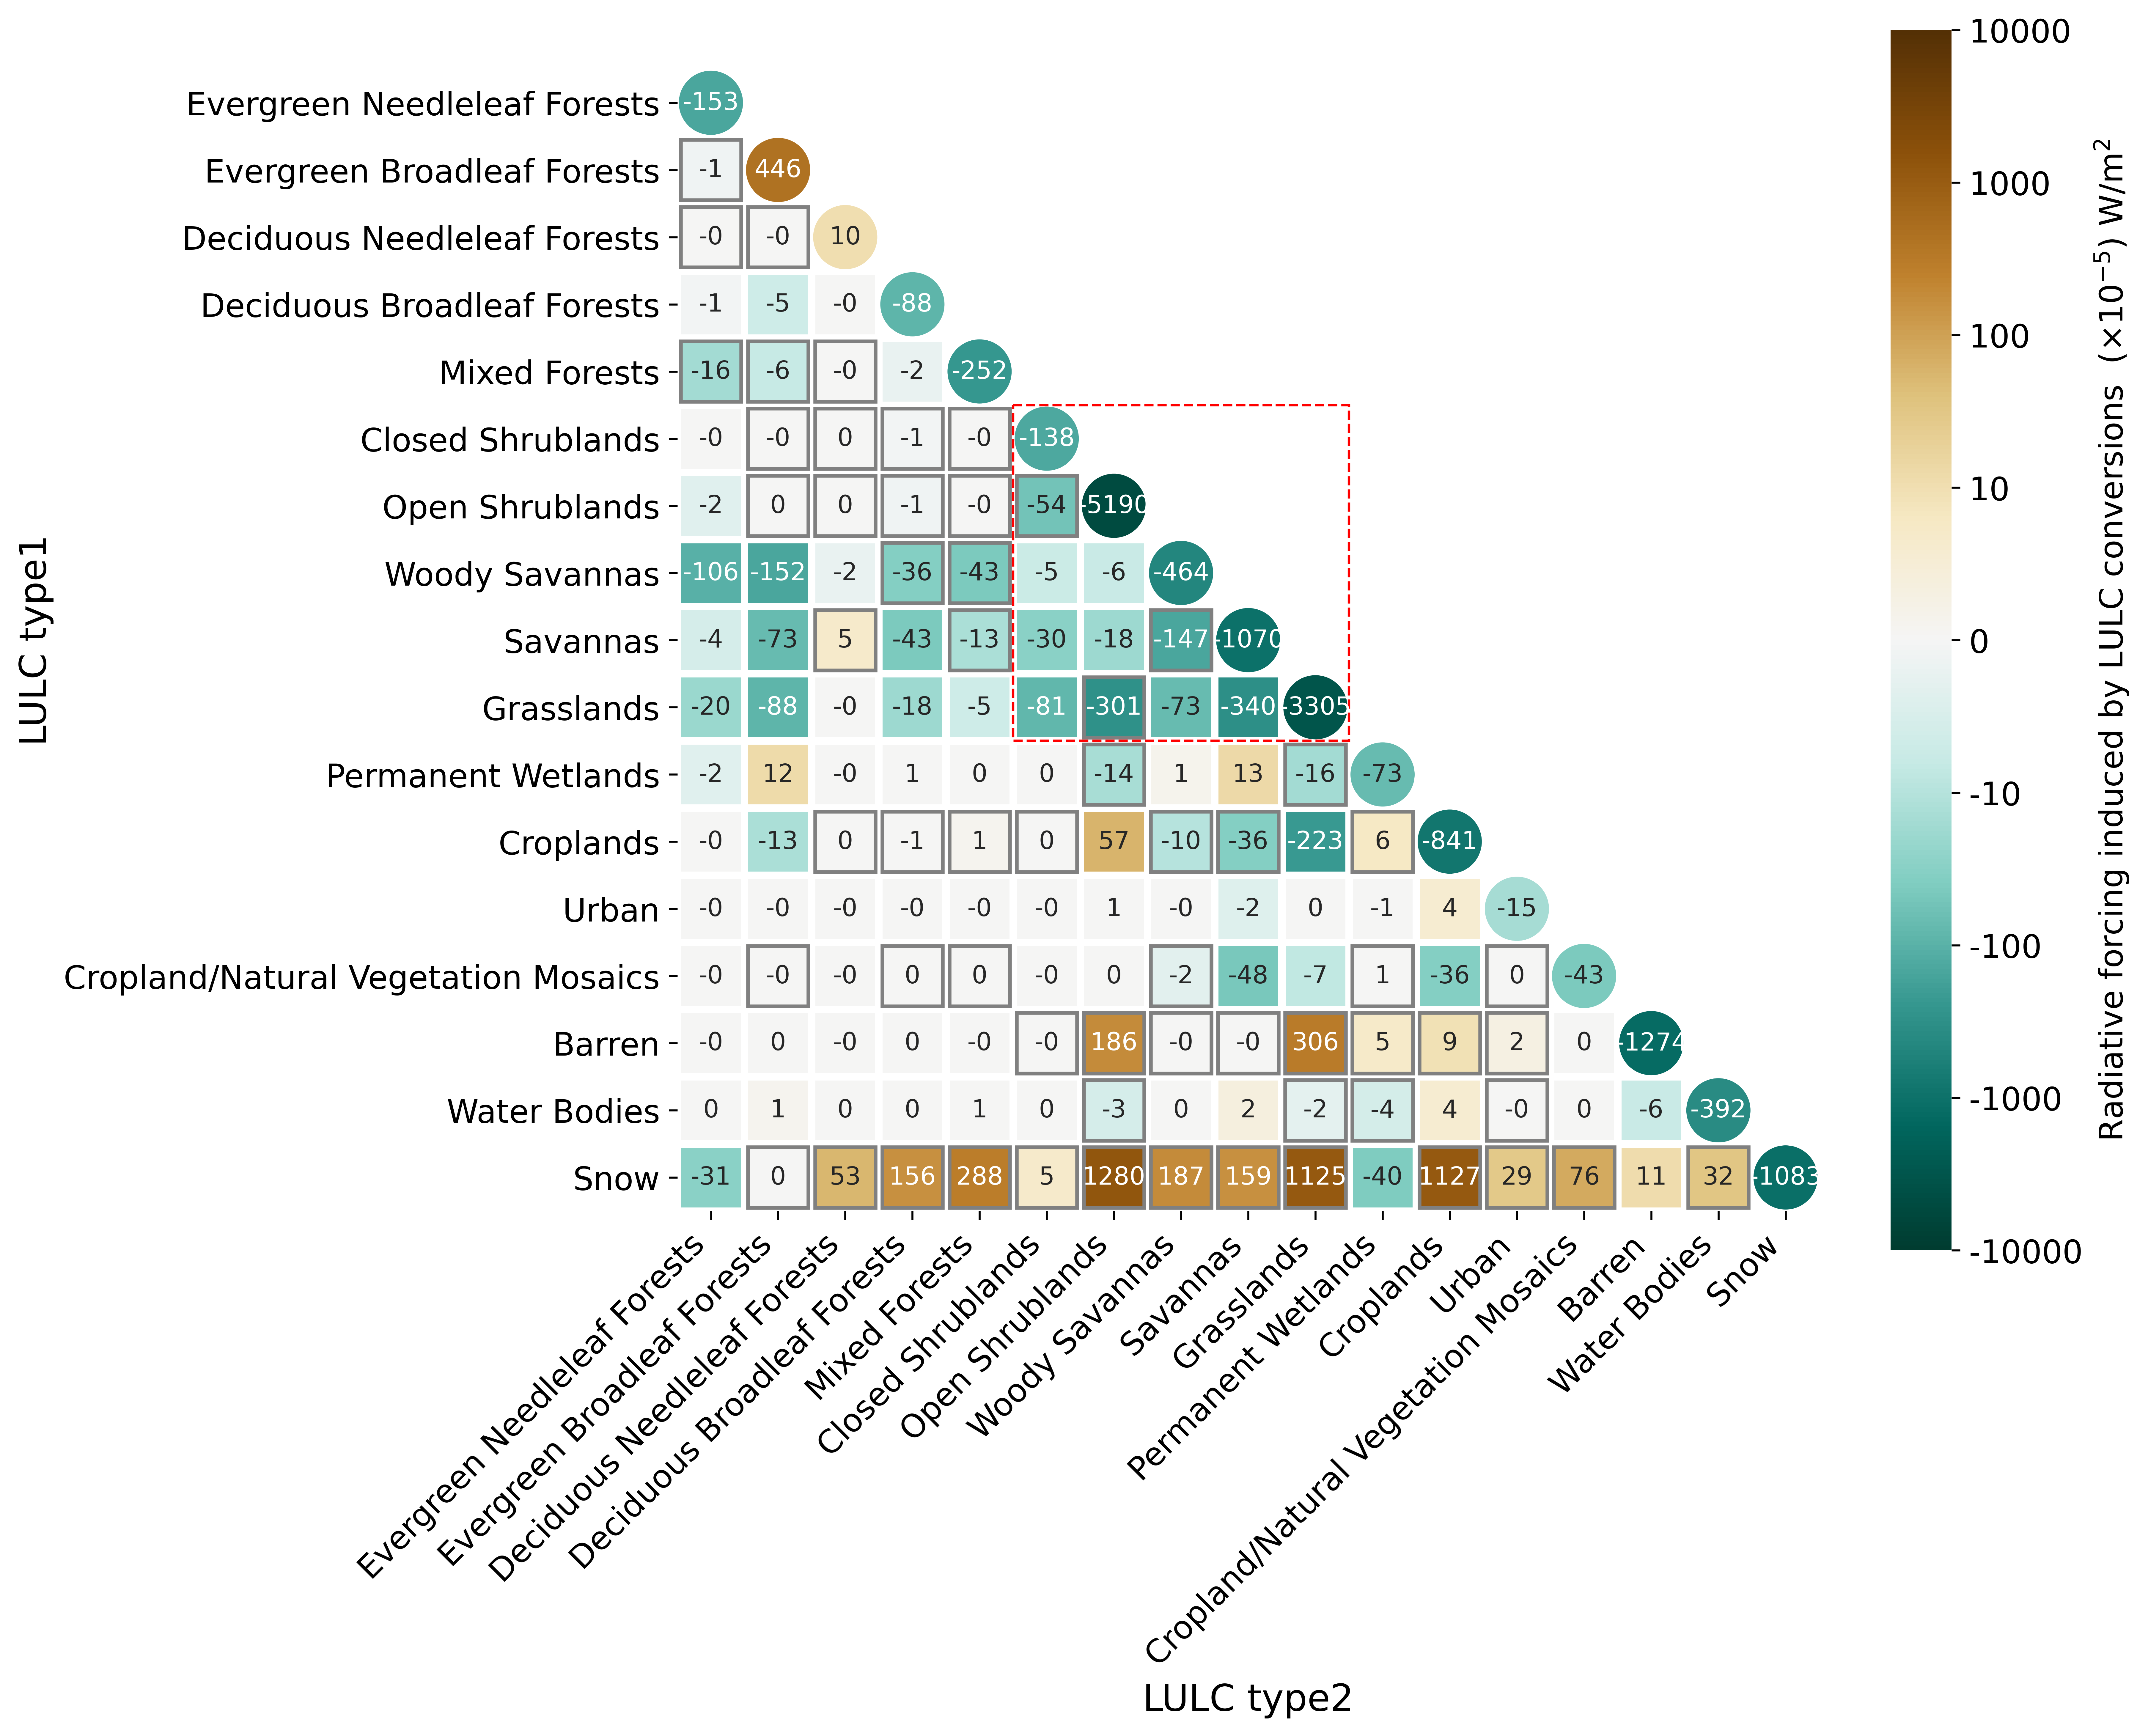

In [13]:
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import seaborn as sns
def heatmap_with_boxes(data, box_indices, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    # ax.imshow(data, **kwargs)

    rows, cols = data.shape

    for i, j in box_indices:
        # 计算框的左下角坐标
        x = j
        y = i

        # 创建框对象并添加到图表中
        rect = Rectangle((x+0.05, y+0.05), 1-0.1, 1-0.1, linewidth=1.5, edgecolor='gray', facecolor='none')
        ax.add_patch(rect)

    ax.set_aspect('equal', adjustable='box')
def heatmap_with_c(data, box_indices, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    # ax.imshow(data, **kwargs)

    rows, cols = data.shape
    cmap = plt.get_cmap('BrBG_r')
    norm = plt.Normalize(vmin=-4, vmax=4)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    for i, j in box_indices:
        # 计算框的左下角坐标
        x = j
        y = i


        value = data[x,y]
        color = sm.to_rgba(value)
        # 创建框对象并添加到图表中
        rect = Circle((x+0.5, y+0.5), 0.45, linewidth=1.5, edgecolor=color, facecolor=color)
        rect2 = Rectangle((x+0.05, y+0.05), 1, 1, linewidth=1.5,  facecolor='white')
        ax.add_patch(rect2)
        ax.add_patch(rect)
        

    ax.set_aspect('equal', adjustable='box')
f, ax = plt.subplots(figsize=(12, 10),dpi=600)
sns.heatmap(dif_al_tranf3, ax=ax,vmin=-4,vmax=4,fmt='g',
            annot_kws={"fontsize":10},square=True,cmap='BrBG_r',
            annot=dif_al_tranf4,linewidths=3,cbar=True)

# ax.set_title('Contribution of LULC conversions to global mean albedo') #plt.title('热图'),均可设置图片标题
ax.set_ylabel('LULC type1',fontsize=15)  #设置纵轴标签
ax.set_xlabel('LULC type2',fontsize=15)  #设置横轴标签
plt.yticks([i+0.5 for i in range(17)],names)
plt.xticks([i+0.5 for i in range(17)],names)
plt.yticks(rotation=360, horizontalalignment='right',fontsize=13)
plt.xticks(rotation=45, horizontalalignment='right',fontsize=13)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-4,-3,-2,-1, 0,1,2,3, 4])
cbar.set_ticklabels(['-10000','-1000','-100','-10', '0','10','100','1000', '10000'],fontsize=13)
cbar.set_label(r"Radiative forcing induced by LULC conversions  ($\times 10^{-5}$) W/m$^2$",fontsize=13)

# box_indices = [(2, 2), (3, 3)]

# 在指定位置添加框
heatmap_with_c(dif_al_tranf3, [(i,i) for i in range(17)], ax=ax)
heatmap_with_boxes(dif_al_tranf3, box_indices, ax=ax)

# plt.axhline(y=5, color='r', linestyle='--', linewidth=1)
# plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=5, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=10, color='r', linestyle='--', linewidth=1)
rect = Rectangle((5, 5), 5, 5, linestyle='--',linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# plt.colorbar(ticks=['10000','1000','100','10','0','-10','-100','-1000','-10000'])
#设置坐标字体方向，通过rotation参数可以调节旋转角度
# label_y = ax.get_yticklabels(names)
# # plt.setp(names, rotation=360, horizontalalignment='right')
# label_x = ax.get_xticklabels(names)
# plt.setp(names, rotation=45, horizontalalignment='right')
plt.tight_layout()
f.savefig('../figure/albedo_RF_kernel_bigfontsize.pdf',dpi=600)
plt.show()

In [ ]:
'''
对比Ghimire和IPCC（CMIP5/6模拟） 1700-2005或者1750-2019土地变化都导致0.15w/m2
大概-0.00049 w/m2/year

'''
#除雪之外的土地转换-草原到草地5种类别的类内转换-森林间的转换+湿地和水体的转换-农田/自然混合类型和农田的转换-裸土相关转换
all=-0.015012936703087445+0.010551542103498745+0.00031854354535260586+3.6697572042134125e-05+0.0003569287131123474-0.0051408864308935005
print(all)
print(all/19)

-0.008890111199975114
-0.0004679005894723744


In [ ]:
'''
对比NC 2001-2018城市扩张导致0.00017w/m2
'''
kka=np.load('/data/hk/albedo/rf_confuse_matrix_kernel2.npy')
# # kka=kka2
kka[np.isnan(kka)]=0
dif_al=kka[:,2018-2001]
dif_al=dif_al.transpose((0,3,4,1,2))
print('type          add         sub               all')
temp=0
temp2=0
all=np.nansum(dif_al)
t=12

print('no snow')
nc=np.nansum(dif_al[:,:,:,t,t])
sub=np.nansum(dif_al[:,:,:,t,-1])-nc
add=np.nansum(dif_al[:,:,:,:-1,t])-nc
print(type_code[t],'     ',
    # to_str(nc/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(add/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(sub/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(((sub+add))/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',)
temp2+=(sub+add)
    # if t==17:
print('have snow')
nc=np.nansum(dif_al[:,:,:,t,t])
sub=np.nansum(dif_al[:,:,:,t])-nc
add=np.nansum(dif_al[:,:,:,:,t])-nc
print(type_code[t],'     ',
    # to_str(nc/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(add/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(sub/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(((sub+add))/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',)
temp2+=(sub+add)


type          add         sub               all
no snow
Urban                          2.06e-05         2.7e-05          4.77e-05        
have snow
Urban                          0.0003562        -0.0002179       0.0001383       
